In [44]:
import tensorflow as tf
from matplotlib import pyplot as plt
from common import *

In [45]:
IMG_PATH = '../COCO/val2017/000000175251.jpg'
MODEL_PATH = '../tflite_models/full/ssd_mobilenetv2.tflite'
LABEL_PATH = 'coco_labels_actual.txt'

In [46]:

interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_img_shape = tuple(input_shape[1:3])
input_type = input_details[0]['dtype']
print(input_shape, input_type)


[  1 320 320   3] <class 'numpy.float32'>


In [47]:
original_img, scaled_img = preprocess_image(IMG_PATH, input_img_shape, input_type)

if input_type == np.float32:
    scaled_img = (2.0 / 255.0) * scaled_img - 1.0

In [48]:
interpreter.set_tensor(input_details[0]['index'], scaled_img)
interpreter.invoke()
bboxes = interpreter.get_tensor(output_details[0]['index']).squeeze()
class_ids = interpreter.get_tensor(output_details[1]['index']).squeeze()
scores = interpreter.get_tensor(output_details[2]['index']).squeeze()
num_detections = interpreter.get_tensor(output_details[3]['index']).squeeze()

In [49]:
# Perform non-max-suppresion and overwrite original outputs
nms_idxs = tf.image.non_max_suppression(
    bboxes,
    scores,
    max_output_size=100,
    iou_threshold=0.4,
    score_threshold=0.5
    )
bboxes = bboxes[nms_idxs]
class_ids = class_ids[nms_idxs]
scores = scores[nms_idxs]

class_ids = class_ids + 1

[ 68 19 609 607 ] 0.77 1.0
[ 299 343 521 410 ] 0.69 90.0


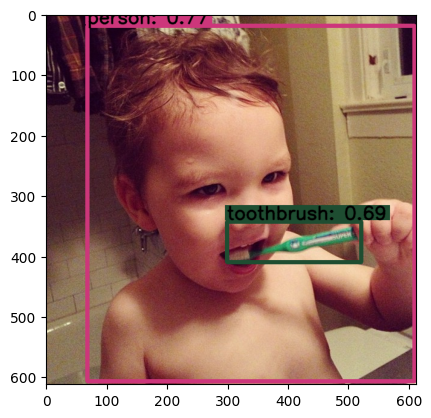

In [50]:
labels = get_coco_labels(LABEL_PATH)
colors = get_colors_from_labels(labels)

for bbox, class_id, score in zip(bboxes, class_ids, scores):
    label = labels[int(class_id)]
    color = tuple([int(c) for c in colors[int(class_id)]])

    y_min_ratio, x_min_ratio, y_max_ratio, x_max_ratio = bbox

    x_min = int(x_min_ratio * original_img.shape[1])
    y_min = int(y_min_ratio * original_img.shape[0])
    x_max = int(x_max_ratio * original_img.shape[1])
    y_max = int(y_max_ratio * original_img.shape[0])

    print('[',x_min, y_min, x_max, y_max,']', f'{score:.2f}', class_id)
    draw_bbox_with_label(original_img, x_min, y_min, x_max, y_max, score, label, color)

plt.imshow(original_img)
